In [156]:
from Functions.data_analysis import *
from Functions.database import getTransaction, getAccount
from Functions.classes import *
from Functions.dicts import *

import numpy as np
import pandas as pd

from scipy.stats import linregress
from matplotlib import pyplot as plt
plt.style.use('fivethirtyeight')


In [157]:
myAcc = getAccount("atlasss")
myAcc.summary()

df = getTransaction(myAcc)

       Username: atlasss
       Password: 1912766d6ba0e50e8b1bacfb51207e83b95b7ac0cd8ce15307cdf4965e7e3f6c
   Date Created: 2024-09-04 04:30:17
   Date Updated: 2024-09-04 04:30:17
        Balance: 10000000


In [158]:
class enrichedData:
    def __init__(self, old_data: pd.DataFrame, data: pd.DataFrame, figsize: tuple[int, int] = (10, 5)) -> None:
        self.old_data = old_data
        self.data = data
        self.figsize = figsize
        
    def plotAll(self, RANGE1: str, RANGE2: str, displacement: tuple[int, ...]):
        _, ax = plt.subplots(figsize=self.figsize)

        if RANGE1 != "YEAR":
            last_data = self.data['Features', RANGE2].iloc[-1] - displacement
            curData = self.data[self.data['Features', RANGE2] == last_data]
            curData = curData.groupby(self.data['Features'][RANGE1]).sum()

            ax.text(0.5, 1.01, f"{RANGE2.title()} {last_data}", ha='center', va='center', transform=ax.transAxes, fontsize=15)
        else:
            curData = self.data.groupby(self.data['Features']['YEAR']).sum()
            last_data = curData.index[-1]

            ax.text(0.5, 1.01, f"All Year", ha='center', va='center', transform=ax.transAxes, fontsize=15)


        plt.xlabel(RANGE1.title())
        plt.ylabel("Rp.")
        plt.title("Complete Plot", pad=20)

        plt.xticks([int(year) for year in curData.index])
    
        curData['Expenses']['TOTAL'].cumsum().plot(ax=ax, label='Cumulative Expenses', alpha=0.6)
        curData['Revenue']['TOTAL'].cumsum().plot(ax=ax, label='Cumulative Revenue', alpha=0.6)
        curData['TOTAL'].cumsum().plot(ax=ax, label='Budget', alpha=0.6)
    
        plt.legend()
        plt.show()

        exported_data = []
        for year in curData.index:
            exported_data.append([
                curData[('Expenses', 'TOTAL')].loc[year],
                curData[('Revenue', 'TOTAL')].loc[year],
                curData[('Revenue', 'TOTAL')].loc[year] - curData[('Expenses', 'TOTAL')].loc[year]
            ])

        print(exported_data)
        
        return exported_data, curData.index[0], len(curData.index)

    
    def plotCategory(self):
        _, ax = plt.subplots(figsize=self.figsize)

        all_types = [0, 1, 2, 3, 4, 5, 10, 11, 12, 13]

        byType = self.old_data.groupby('TYPE')['VALUE'].sum().reset_index()
        byType = byType.set_index('TYPE').reindex(all_types, fill_value=0).reset_index()
        byType['TYPE_LABEL'] = byType['TYPE'].map(typeMapping)
        byType = byType.sort_values("VALUE", ascending=False)

        colors = ["red" if type_val < 10 else "green" for type_val in byType['TYPE']]
        plt.bar(byType['TYPE_LABEL'], byType['VALUE'], color=colors)

        plt.xlabel('Type')
        plt.xticks(rotation=45, ha='right')
        plt.ylabel('Rp.')
        plt.title('Expenses by Type')
        ax.text(0.5, 1.01, f"All Year", ha='center', va='center', transform=ax.transAxes, fontsize=15)
        
        plt.show()


        exported_data = []
        for i in byType.index:
            exported_data.append([
                byType['TYPE_LABEL'][i], 
                byType['VALUE'].loc[i]
            ])

        return exported_data

    def getLinReg(self):
        data = self.data

        totalYear = self.data['Features'].iloc[-1]['YEAR'] - self.data['Features'].iloc[0]['YEAR'] + 1

        linreg = []
        for y in ['Expenses', 'Revenue']:
            curtype = []
            for x in ['DAY', 'WEEK', 'MONTH', 'QUARTER', 'YEAR']:
                cur_data = data.copy()
                cur_data[x] = cur_data['Features'][x]
                cur_data = cur_data.groupby(x, as_index=False)[y].sum()
                cur_data['Cumulative'] = cur_data[y]['TOTAL'].cumsum()

                slope, intercept, r_value, p_value, std_err = linregress(cur_data[x], cur_data['Cumulative'])

                slope /= totalYear

                curtype.append(slope)
            
            linreg.append(curtype)

        curtype = []
        for i in range(5):
            curtype.append(linreg[1][i] - linreg[0][i])
        
        linreg.append(curtype)

        return linreg
    
    def plotTimeCycle(self, x: int):
        if x < 0 or x > 4:
            return

        _, ax = plt.subplots(figsize=self.figsize)

        time_cycle = ["DoW", "WoM", "MONTH", "QUARTER", "YEAR"][x]
        time_dict = [dayMapping, weekMapping, monthMapping, quarterMapping, None][x]
        title = ["Day", "Week", "Month", "Quarter", "Year"][x]

        cur_data = self.data.copy()
        cur_data[time_cycle] = cur_data['Features'][time_cycle]

        if time_cycle == "WoM":
            cur_data[time_cycle] = cur_data[time_cycle].replace(6, 5)
        
        # Your code block to process cur_data
        cur_data['ET'] = cur_data[('Expenses', 'TOTAL')]
        cur_data['RT'] = cur_data[('Revenue', 'TOTAL')]
        cur_data = cur_data.sort_index(axis=1)
        cur_data = cur_data.drop(columns=['Features'])

        cur_data = cur_data.groupby(time_cycle, as_index=False).sum()

        # Continue with the rest of the logic
        cur_data.loc[:, ('Expenses', 'TOTAL')] = cur_data[('Expenses', 'TOTAL')] - cur_data[('Expenses', '5')]

        indices = np.arange(len(cur_data))
        bar_width = 0.35

        plt.bar(indices, cur_data[('Expenses', 'TOTAL')], width=bar_width, label='Expenses')
        plt.bar(indices + bar_width, cur_data[('Revenue', 'TOTAL')], width=bar_width, label='Revenue')

        if time_cycle != "YEAR":
            cur_data['LABEL'] = cur_data[time_cycle].map(time_dict).fillna("Unknown")
        else:
            cur_data['LABEL'] = cur_data[time_cycle].astype(str)

        plt.xlabel(title)
        if time_cycle == "MONTH":
            plt.xticks(indices + bar_width / 2, cur_data['LABEL'], rotation=45, ha='right')
        else:
            plt.xticks(indices + bar_width / 2, cur_data['LABEL'])
        plt.ylabel('Rp.')
        plt.title(f'{title} Distribution')
        plt.legend()

        exported_data = []
        for i in cur_data.index:
            exported_data.append([
                cur_data['ET'].loc[i],
                cur_data['RT'].loc[i]
            ])

        if time_cycle == "YEAR":
            start = cur_data['YEAR'].loc[0]
        else:
            start = None

        return title, exported_data, start



In [159]:
def enrichData(df: pd.DataFrame) -> enrichedData:
  old_data = df.copy()
  def WoM(dt):
    """ Returns the week of the month for the specified date. """
    first_day = dt.replace(day=1)
    dom = dt.day
    adjusted_dom = dom + first_day.weekday()
    
    return int(np.ceil(adjusted_dom / 7.0))

  df['UPDATED_AT'] = pd.to_datetime(df['UPDATED_AT'])
  df = df.drop(columns=['CREATED_AT', 'TRANSACTION_ID', 'ITEM', 'USERNAME']).set_index('UPDATED_AT').sort_index()
  
  
  expenses = pd.concat([
    df[(df['CATEGORY'] == 0) & (df['TYPE'] == i)]
    .drop(columns=['CATEGORY', 'TYPE'])
    .resample('D')
    .sum()
    .rename(columns={'VALUE': f'{i}'})
    for i in df[df['CATEGORY'] == 0]['TYPE'].unique()
  ], axis=1)

  
  revenue = pd.concat([
    df[(df['CATEGORY'] == 1) & (df['TYPE'] == i)]
    .drop(columns=['CATEGORY', 'TYPE'])
    .resample('D')
    .sum()
    .rename(columns={'VALUE': f'{i}'})
    for i in df[df['CATEGORY'] == 1]['TYPE'].unique()
  ], axis=1)

  expenses = expenses.reindex(sorted(expenses.columns, key=lambda x: int(x)), axis=1)
  revenue = revenue.reindex(sorted(revenue.columns, key=lambda x: int(x)), axis=1)


  expenses.columns = pd.MultiIndex.from_product([['Expenses'], expenses.columns])
  revenue.columns = pd.MultiIndex.from_product([['Revenue'], revenue.columns])

  expenses[('Expenses', 'TOTAL')] = expenses.sum(axis=1)
  revenue[('Revenue', 'TOTAL')] = revenue.sum(axis=1)


  features = pd.DataFrame(index=expenses.index.union(revenue.index))
  features[("Features", "DoW")] = features.index.day_of_week
  features[("Features", "DoM")] = features.index.day
  features[("Features", "WoM")] = features.index.map(WoM)
  features[("Features", "DAY")] = features.index.day_of_year
  features[("Features", "WEEK")] = features.index.isocalendar().week
  features[("Features", "QUARTER")] = features.index.quarter
  features[("Features", "MONTH")] = features.index.month
  features[("Features", "YEAR")] = features.index.year

  DATA = pd.concat([expenses, revenue, features], axis=1).fillna(0)
  
  DATA.index.name = "DATE"
  DATA['TOTAL'] = DATA['Revenue', 'TOTAL'] - DATA['Expenses', 'TOTAL']

  return enrichedData(old_data, DATA)


In [160]:
myData = enrichData(df)

2022


('Year',
 [[10693000.0, 38000000.0],
  [126527000.0, 122000000.0],
  [18072000.0, 31000000.0]],
 0)

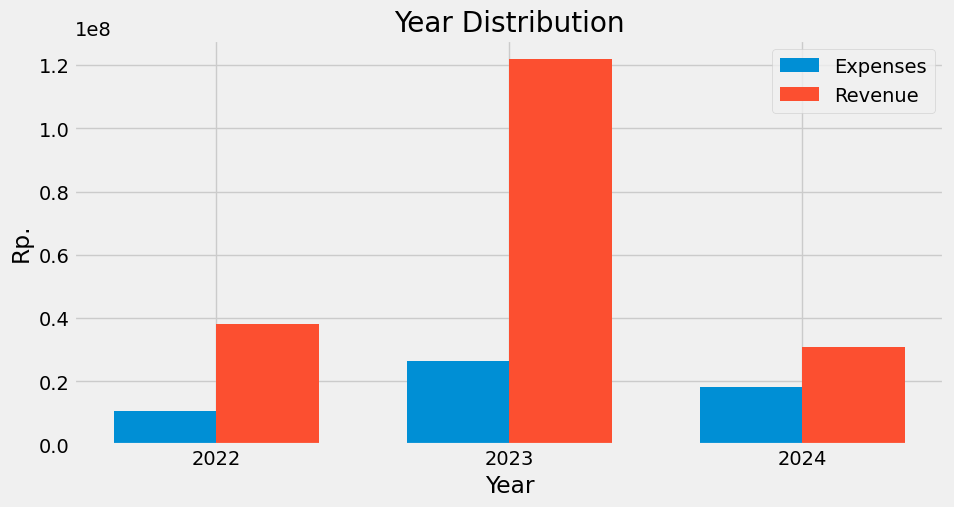

In [161]:
myData.plotTimeCycle(4)